In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sliced.datasets import make_cubic
from sliced import SlicedInverseRegression
from sliced import SlicedAverageVarianceEstimation
from sliced import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y

In [7]:
x1Restruct_Fun=np.zeros([604,1704])
x2Restruct_Fun=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1Restruct_Fun[i][j*24+k]=a[k]

#x2 (1704th~6815th column as x)
for i in range (1,605):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2Restruct_Fun[i-1][j]=b[j]
        
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [8]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [9]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [14]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([539,6816])
Yhat_train = np.zeros([539,5112])

for i in range (2,541):
    for j in range (0,1704):
        Xhat_train[i-2][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i-2][j+1704] = Xhat[i][j+1704]
        Yhat_train[i-2][j] = Yhat[i][j]

In [17]:
###
#cal_PMf  
###
XR=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    XR[i]=a.T

###
#obs_PMf
###
YR=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    YR[i]=a.T
    
Xh=XR
Yh=YR
Xhat_val = np.zeros([61,6816])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,6816])
Yhat_test = np.zeros([61,5112])
        
for i in range (544,605):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*(i-1)+72*j:5112*(i-1)+72*j+24])
        for k in range (0,24):
            Xhat_val[i-544][j*24+k]=a[k]
    for j in range (0,5112):
        Xhat_val[i-544][1704+j] = Xh[i][j]
        Yhat_val[i-544][j] = Yh[i][j]     
        
for i in range (544,605):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*(i-1)+72*j:5112*(i-1)+72*j+24])
        for k in range (0,24):
            Xhat_test[i-544][j*24+k]=a[k]
    for j in range (0,5112):
        Xhat_test[i-544][1704+j] = Xh[i][j]
        Yhat_test[i-544][j] = Yh[i][j]

In [18]:
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(539, 6816)
Yhat_train
(539, 5112)
Xhat_val
(61, 6816)
Yhat_val
(61, 5112)
Xhat_test
(61, 6816)
Yhat_test
(61, 5112)


## Sparse and Expend data

In [19]:
X1hat_train = np.zeros([539,1704])
X2hat_train = np.zeros([539,5112])
X1hat_test = np.zeros([61,1704])
X2hat_test = np.zeros([61,5112])
for i in range (0,539):
    for j in range (0,1704):
        X1hat_train[i][j] = Xhat_train[i][j]
    for j in range (1704,6816):
        X2hat_train[i][j-1704] = Xhat_train[i][j]
for i in range (0,61):
    for j in range (0,1704):
        X1hat_test[i][j] = Xhat_test[i][j]    
    for j in range (1704,6816):
        X2hat_test[i][j-1704] = Xhat_test[i][j]
        
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))

X1hat_train
(539, 1704)
X2hat_train
(539, 5112)
X1hat_test
(61, 1704)
X2hat_test
(61, 5112)


In [20]:
new_x=np.zeros([539*72,6816]) #38880
new_y=np.zeros([539*72,5112]) #38880
#new_x : 0th~1703th column
for i in range (0,72):
    for j in range (0,539):
        for k in range (0,1704):
            new_x[539*i+j][k]=X1hat_train[j][k]
#new_x : 1704th~6815th column
for i in range (0,72):
    for j in range (0,539):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_x[539*i+j][1704+k]=X2hat_train[j][k]
#new_y
for i in range (0,72):
    for j in range (0,539):
        for k in range (0,5112):
            new_y[539*i+j][k]=Yhat_train[j][k]         

print(np.shape(new_x))
print(np.shape(new_y))

(38808, 6816)
(38808, 5112)


In [21]:
new_exx=np.zeros([61*72,6816]) #38880
new_eyy=np.zeros([61*72,5112]) #38880
#new_exx : 0th~1703th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,1704):
            new_exx[61*i+j][k]=X1hat_test[j][k]
#new_exx : 1704th~6815th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_exx[61*i+j][1704+k]=X2hat_test[j][k]
#new_eyy
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,5112):
            new_eyy[61*i+j][k]=Yhat_test[j][k]         

print(np.shape(new_exx))
print(np.shape(new_eyy))

(4392, 6816)
(4392, 5112)


# Original Data

In [22]:
error1 = mean_absolute_error(Xhat_test[:,1704:], Yhat_test)
error2 = mean_squared_error(Xhat_test[:,1704:], Yhat_test)
print('testing data MAE is ',error1)
print('testing data MAE is ',error2)

testing data MAE is  6.919742865451666
testing data MAE is  90.30246788296535


# Mix Model

## 公式解（PCA + Linear regression）

In [23]:
x = new_x
y = new_y
xt = new_exx
yt = Yhat_test

In [24]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [25]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        fit95=np.zeros([61,5112])
        for i in range (0,72):
            for j in range (0,61):
                for k in range (0,71):
                    fit95[j][72*k+i]=fit[61*i+j][72*k+i]
        mae = np.mean(abs(fit95-yt))
        mse = np.mean((fit95-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [26]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  90.0 % Y =  85.0 % have the min MAE error : 5.54447114861635
(0.9, 0.85, 5.54447114861635)
test data on x =  90.0 % Y =  85.0 % have the min MSE error : 54.3630035104983
(0.9, 0.85, 54.3630035104983)


## Gradient descent (loss = MAE)

In [27]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [28]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [29]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([1704,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

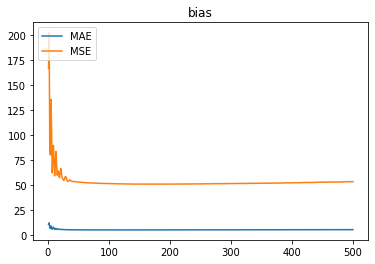

In [30]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [31]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.210120142469372
testing data MAE is  50.89673345185711


## Gradient descent (loss = MSE)

In [32]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [33]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [34]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([1704,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

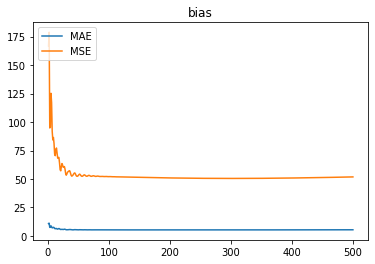

In [35]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [36]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.311074936301592
testing data MAE is  50.50214700911623


## Gradient descent (loss = Huber loss)

In [37]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [38]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [39]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([1704,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

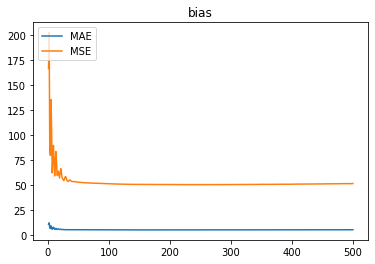

In [40]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [41]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.197394130336199
testing data MAE is  50.5148762101488


# Function on Function Model

## 公式解（PCA + Linear regression）

In [42]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [43]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [44]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        
        mae = np.mean(abs(fit-yt))
        mse = np.mean((fit-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [45]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  85.0 % Y =  85.0 % have the min MAE error : 5.2699263061437005
(0.85, 0.85, 5.2699263061437005)
test data on x =  85.0 % Y =  85.0 % have the min MSE error : 47.07454856032148
(0.85, 0.85, 47.07454856032148)


## Gradient descent (loss = MAE)

In [46]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [47]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [48]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([6816,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

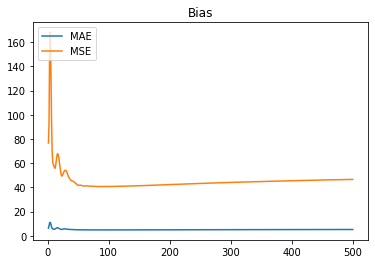

In [49]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [50]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.837582193818432
testing data MAE is  40.675063923328274


## Gradient descent (loss = MSE)

In [51]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [52]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [53]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([6816,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

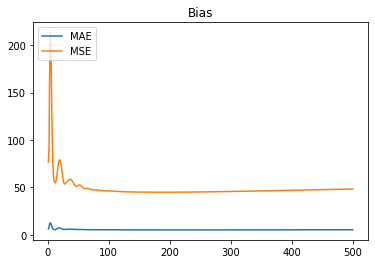

In [54]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [55]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.148560643045418
testing data MAE is  44.910104802549114


## Gradient descent (loss = Huber loss)

In [56]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [57]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [58]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([6816,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

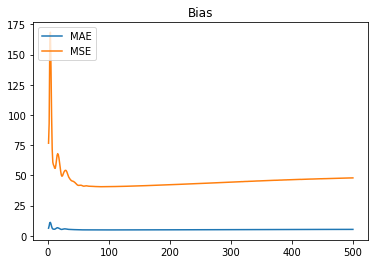

In [59]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [60]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.834356543263711
testing data MAE is  40.61789162772465


# PLS Model

In [61]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [62]:
test_error_MAE = 100*np.ones(50)
test_error_MSE = 100*np.ones(50)
for n in range (1,51):
    model = PLSRegression(n_components=n,max_iter=1000)
    model.fit(x, y)

    xf=Xhat_test
    xfit=model.predict(xf)
    
    after_MAE=np.nanmean(abs(xfit-yt))
    after_MSE=np.nanmean((xfit-yt)**2)
    
    test_error_MAE[n-1] = after_MAE
    test_error_MSE[n-1] = after_MSE

In [63]:
print('test data on n = ', np.argmin(test_error_MAE)+1, 'have the min MAE error : ', min(test_error_MAE))
print('test data on n = ', np.argmin(test_error_MSE)+1, 'have the min MSE error : ', min(test_error_MSE))

test data on n =  12 have the min MAE error :  5.164806215915351
test data on n =  12 have the min MSE error :  45.39657861744201


# SIR Model

In [64]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [65]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.90
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = np.zeros(3)
yper[0] = 0.95
yper[1] = 0.99
yper[2] = 0.995
slices = np.zeros(5)
slices[0] = 10
slices[1] = 20
slices[2] = 30
slices[3] = 40
slices[4] = 50
test_error_MAE = 100*np.ones(15)
test_error_MSE = 100*np.ones(15)
index_MAE = []
index_MSE = []

In [66]:
for q in range (0,5):
    for r in range(0,3):
        pca_x = PCA(n_components=xper[q])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        a = x_pca.shape[1]

        pca_y = PCA(n_components=yper[r])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        b = y_pca.shape[1]

        xt_pca=pca_x.transform(xt)

        xt_svr = np.zeros([5,61,b])
        #5是因為有5種n_slices
        for j in range (0,5):
            for i in range (0,b):
                sir_x = SlicedInverseRegression(n_slices=slices[j])
                sir_x.fit(x_pca, y_pca[:,i])
                x_sir = sir_x.transform(x_pca)
                   
                svr = SVR()
                svr.fit(x_sir, y_pca[:,i])
                
                xt_sir = sir_x.transform(xt_pca) 
                xt_svr[j][:,i]=svr.predict(xt_sir)
        error1 = np.zeros(5)
        error2 = np.zeros(5)
        for i in range (0,5):
            yt_inv = pca_y.inverse_transform(xt_svr[i])
            error1[i] = np.mean(abs(yt_inv-yt))
            error2[i] = np.mean((yt_inv-yt)**2)

        n1 = 10*(np.argmin(error1)+1)
        n2 = 10*(np.argmin(error2)+1)
        min1 = min(error1)
        min2 = min(error2)
        index_MAE.append((xper[q], yper[r], n1, min1))    
        index_MSE.append((xper[q], yper[r], n2, min2)) 
        test_error_MAE[3*q+r] = min1
        test_error_MSE[3*q+r] = min2

In [67]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on n_slices = ', index_MAE[f1][2], ', x = ', index_MAE[f1][0], '% , y = ', index_MAE[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(index_MAE[f1])
print('test data on n_slices = ', index_MSE[f2][2], ', x = ', index_MSE[f2][0], '% , y = ', index_MSE[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(index_MSE[f2])

test data on n_slices =  10 , x =  0.9 % , y =  0.95 % have the min MAE error : 5.267391974832296
(0.9, 0.95, 10, 5.267391974832296)
test data on n_slices =  10 , x =  0.9 % , y =  0.95 % have the min MSE error : 47.4088611910441
(0.9, 0.95, 10, 47.4088611910441)


# CNN Model

In [68]:
Xhat_train_n = np.zeros([71,539,96])
Yhat_train_n = np.zeros([71,539,72])
Xhat_test_n = np.zeros([71,61,96])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,539):
        for k in range (0,24):
            Xhat_train_n[i][j][k] = Xhat_train[j][24*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+24] = Xhat_train[j][1704+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,24):
            Xhat_test_n[i][j][k] = Xhat_test[j][24*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+24] = Xhat_test[j][1704+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val=Xhat_test_n
Yhat_val=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))

Xhat_train
(71, 539, 96)
Yhat_train
(71, 539, 72)
Xhat_test
(71, 61, 96)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 96)
Yhat_val
(71, 61, 72)


## loss = MAE

In [69]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(91*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model2", name="CNN_96hr_MAE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [71]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model2/CNN_96hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

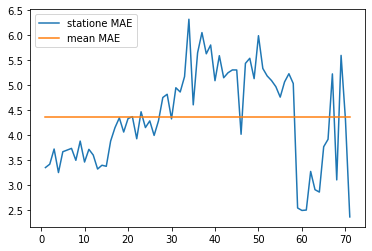

In [72]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

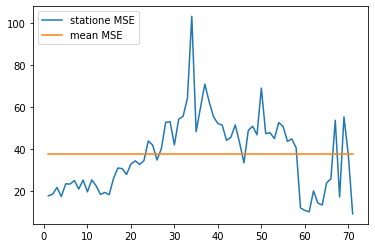

In [73]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [74]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.365464898901926
testing data MAE is  37.55859469024228


## loss = MSE

In [75]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(91*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model2", name="CNN_96hr_MSE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [77]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model2/CNN_96hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

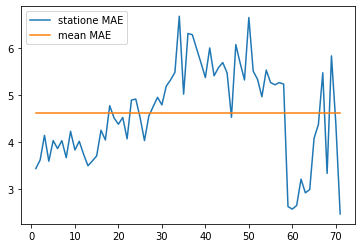

In [78]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

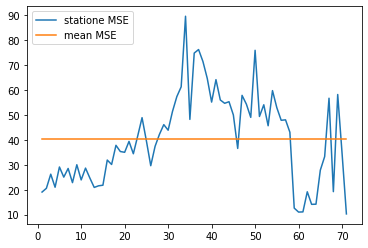

In [79]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [80]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.618318477147062
testing data MAE is  40.31716380320804


## loss = Huber loss

In [81]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(91*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model2", name="CNN_96hr_Huber")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [83]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model2/CNN_96hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

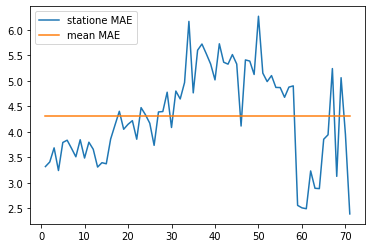

In [84]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

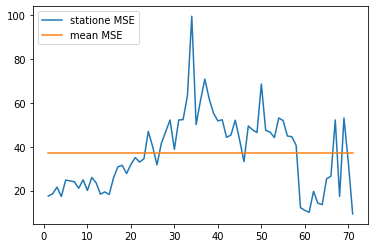

In [85]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [86]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.31125305068325
testing data MAE is  37.19257487713451


# Transformer Model

In [ ]:
Xhat_train_n = np.zeros([71,539,96])
Yhat_train_n = np.zeros([71,539,72])
Xhat_test_n = np.zeros([71,61,96])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,539):
        for k in range (0,24):
            Xhat_train_n[i][j][k] = Xhat_train[j][24*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+24] = Xhat_train[j][1704+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,24):
            Xhat_test_n[i][j][k] = Xhat_test[j][24*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+24] = Xhat_test[j][1704+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

In [ ]:
Xhat_train_n0 = np.zeros([71, 539, 168])
Xhat_val_n0 = np.zeros([71, 61, 168])
Xhat_test_n0 = np.zeros([71, 61, 168])
for k in range(0,71):
    for i in range (0,539):
        for j in range (0,96):
            Xhat_train_n0[k][i][j] = Xhat_train_n[k][i][j]
        for j in range (96,168):
            Xhat_train_n0[k][i][j] = Yhat_train_n[k][i][j-96]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,96):
            Xhat_val_n0[k][i][j] = Xhat_val_n[k][i][j]
        for j in range (96,168):
            Xhat_val_n0[k][i][j] = Yhat_val_n[k][i][j-96]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,96):
            Xhat_test_n0[k][i][j] = Xhat_test_n[k][i][j]
        for j in range (96,168):
            Xhat_test_n0[k][i][j] = Yhat_test_n[k][i][j-96]
print('Xhat_train')
print(np.shape(Xhat_train_n0))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n0))
print('Yhat_test')
print(np.shape(Yhat_test_n))
print('Xhat_val')
print(np.shape(Xhat_val_n0))
print('Yhat_val')
print(np.shape(Yhat_val_n))

## loss = MAE

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(96,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:96])
        ouput = self.layer2(ouput, x[:,96:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model_f", name="Transformer_96hr_MAE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [ ]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model_f/Transformer_96hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

In [ ]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [ ]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

## loss = MSE

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(96,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:96])
        ouput = self.layer2(ouput, x[:,96:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model_f", name="Transformer_96hr_MSE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [ ]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model_f/Transformer_96hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

In [ ]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [ ]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

## loss = Huber loss

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(96,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:96])
        ouput = self.layer2(ouput, x[:,96:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model_f", name="Transformer_96hr_Huber")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [ ]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model_f/Transformer_96hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

In [ ]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [ ]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))